## Trees Land Cover Analysis 

We wanted to look for the forest pattern in the D48 region from a land cover/ land use point of view. We used Esri 10m Land Use/Land Cover (9-class) product (lulc-9-class) for years 2017 and 2021 to see the 5-years difference especially in the trees class. 

In [123]:
from matplotlib.colors import ListedColormap
import pystac_client
from pystac.extensions.projection import ProjectionExtension as proj

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer
import rasterio
import rasterio.features
import stackstac
import xarray as xr 
import seaborn as sns

from matplotlib import pyplot
from rasterio.plot import show

We import the lulc-9-class dataset class names.

In [124]:
from pystac.extensions.item_assets import ItemAssetsExtension
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

collection = catalog.get_collection("io-lulc-9-class")
ia = ItemAssetsExtension.ext(collection)

x = ia.item_assets["data"]
class_names = {x["summary"]: x["values"][0] for x in x.properties["file:values"]}
values_to_classes = {v: k for k, v in class_names.items()}
class_count = len(class_names)
class_names

{'No Data': 0,
 'Water': 1,
 'Trees': 2,
 'Flooded vegetation': 4,
 'Crops': 5,
 'Built area': 7,
 'Bare ground': 8,
 'Snow/ice': 9,
 'Clouds': 10,
 'Rangeland': 11}

We create a colormap similar to the dataset's color definitions so it would be used when rendering the raster tiffs. 

In [125]:

with rasterio.open(item.assets["data"].href) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(max(class_names.values()))
    ]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

<AxesSubplot: title={'center': 'Land Cover 2021'}>

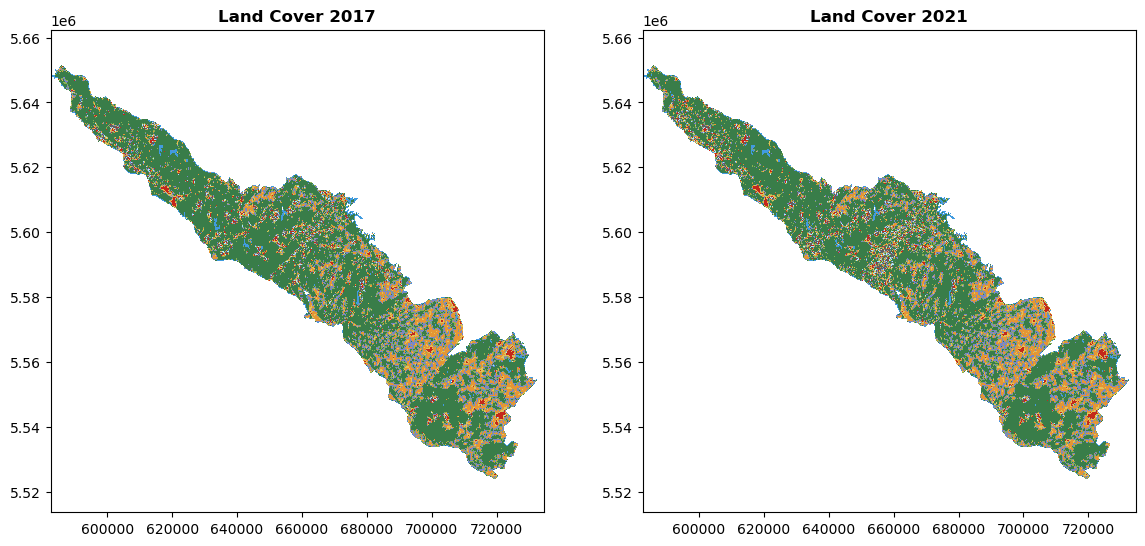

In [126]:
fig, (ds2017, ds2021) = pyplot.subplots(1,2, figsize=(14, 7))

raster2017 = rasterio.open("/home/sc.uni-leipzig.de/my982hzao/ForestCoverPatternStudy/Cropped D48/2017.tif")
raster2021 = rasterio.open("/home/sc.uni-leipzig.de/my982hzao/ForestCoverPatternStudy/Cropped D48/2021.tif")

show((raster2017, 1), ax=ds2017, title= "Land Cover 2017", cmap=cmap)
show((raster2021, 1), ax=ds2021, title= "Land Cover 2021", cmap=cmap)

Reading the rasters into a dataset, then parsing the dataset to an xarray.DataArray object to facilitate later analysis. 

In [127]:
dataset2017 = raster2017.read()

landCover2017 = xr.DataArray(

    dataset2017, 
    dims = ['time','y', 'x'],  
    coords=dict(
         time=np.array(['2017-01-01'], dtype='datetime64')),
    attrs=dict(
        crs = "epsg:32632",
        resolution=10.0,
        transform = raster2017.transform
    ),
    name = "LandCover2017")

In [128]:
dataset2021 = raster2021.read()

landCover2021 = xr.DataArray(
    dataset2021, 
    dims = ['time','y', 'x'],
    coords=dict(
        time=np.array(['2021-01-01'], dtype='datetime64')),
    attrs=dict(
        crs = "epsg:32632",
        resolution=10.0,
        transform = raster2017.transform
    ),
    name = "LandCover2021")

Both DataArrays from 2017 and 2021 are merged into one. 

In [130]:
merged  = xr.concat([landCover2017, landCover2021],'time')

In [131]:
df = merged.stack(pixel=("y", "x")).T.to_pandas()

Creating a heatmap to show the transitions land use from which class to which class. 

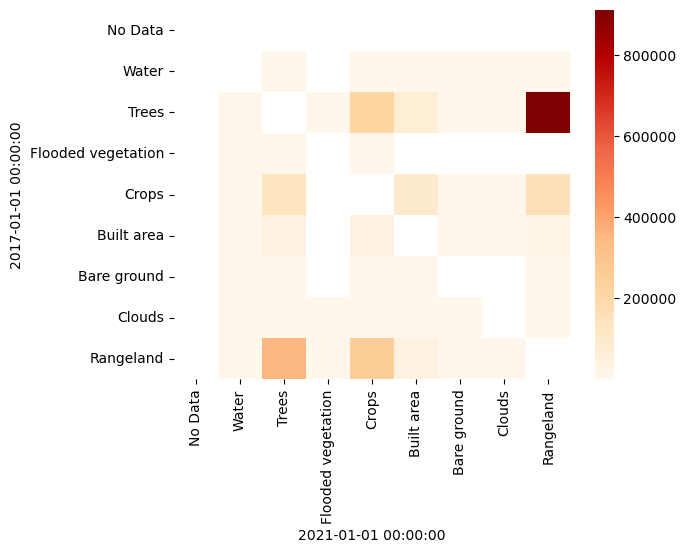

In [132]:
by_year = df.groupby("2017-01-01")["2021-01-01"].value_counts()

values_to_classes = {v: k for k, v in class_names.items()}

years = by_year.index.levels[0]
classes = by_year.index.levels[1]

idx = pd.MultiIndex.from_product([years, classes])
transitions = by_year.reindex(idx, fill_value=0)
by_year[by_year.index.get_level_values(0) == by_year.index.get_level_values(1)] = np.nan

transitions = by_year.unstack().rename(
    columns=values_to_classes, index=values_to_classes
)

heatmap = sns.heatmap(transitions, cmap="OrRd");



In [133]:
transitions


2021-01-01 00:00:00,No Data,Water,Trees,Flooded vegetation,Crops,Built area,Bare ground,Clouds,Rangeland
2017-01-01 00:00:00,,,,,,,,,
No Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water,NaN,NaN,5084.0,NaN,2271.0,865.0,960.0,46.0,1089.0
Trees,NaN,3234.0,NaN,1.0,219971.0,74519.0,615.0,208.0,912867.0
Flooded vegetation,NaN,37.0,63.0,NaN,45.0,NaN,NaN,NaN,NaN
Crops,NaN,2818.0,139243.0,NaN,NaN,102060.0,75.0,52.0,158160.0
Built area,NaN,878.0,40103.0,NaN,36072.0,NaN,1501.0,155.0,21409.0
Bare ground,NaN,115.0,811.0,NaN,672.0,2887.0,NaN,NaN,1500.0
Clouds,NaN,57.0,714.0,4.0,185.0,1137.0,70.0,NaN,627.0
Rangeland,NaN,1477.0,353008.0,20.0,256616.0,36349.0,1359.0,366.0,NaN


Retrieving the number of the 10m by 10m Trees class pixels (denoted by uint=2) from 2017. 

In [134]:
treesTotal = np.where(landCover2017.stack(pixel=("y", "x")) == 2)
treesTotal = treesTotal[0].size
treesTotal

28751231

Calculating the percentage decrease in the trees in 2017 to rangelands in 2021 (a land composed of grass and scrubs vegetation)

In [135]:
treesToRangeland = transitions.loc['Trees']['Rangeland']
treesToRangeland

percentageLoss = treesToRangeland/treesTotal*100
percentageLoss 

3.17505361770423

Calculating the percentage increase in the trees in 2021 from rangelands in 2017

In [136]:
rangelandToTrees = transitions.loc['Rangeland']['Trees']
rangelandToTrees

percentageGain = rangelandToTrees/treesTotal*100
percentageGain

1.2278013417929827

///TODO: compare the percentages to other lit, what can we draw from this? </br>


///TODO: Add other classes to comparison not only rangeland but crops + built areas